In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

figsize = (12,5)
sns.set(rc={'figure.figsize':figsize})
sns.set_theme(style="darkgrid")
plt.style.use("dark_background")

In [2]:
gh_ranking = pd.read_csv('github-ranking-2023-08-12.csv')
repos = set()
for index, row in gh_ranking.iterrows():
    repos.add(row['username'] + "/" + row['repo_name'])

# Seed the random number generator with a constant so we pick the same repos
# each time. Comment this out for actual randomness.
random.seed(62_420)

number_of_repos = 200
# We'll pick 200 repos, which is probably overkill.
repos = random.choices(list(repos), k=number_of_repos)

In [3]:
from github import Github
from github import Auth
from dotenv import load_dotenv
import os

load_dotenv()

gh_token = os.environ["GITHUB_ACCESS_TOKEN"]
auth = Auth.Token(gh_token)

g = Github(auth=auth)

contributions = {}

for repo in repos:
    repo = g.get_repo(repo)
    stats = repo.get_stats_contributors()
    if not stats:
        continue
    for stat in stats:
        login = stat.author.login
        if login not in contributions:
            contributions[login] = {"commits": 0, "lines_changed": 0}
        contributions[login]["commits"] += stat.total
        for week in stat.weeks:
            # sum additions and deletions
            contributions[login]["lines_changed"] += week.a + week.d


In [4]:
df = pd.DataFrame.from_dict(contributions,orient='index')
df.index.name = 'login'
df

,commits,lines_changed
login,,
TheNiv,1,2
n3tl0kr,1,2
zmbf0r3ns1cs,1,6
itpropaul,1,2
netscylla,2,25
...,...,...
grabbou,82,57220
janicduplessis,291,36832
philikon,57,9660


In [5]:
def displot(df, filename, bins, title):
    fig = sns.displot(df, bins=bins, height=5, aspect=2)
    fig.set(title=title)
    fig.set(xlim=(0, df.max()))
    plt.tight_layout()
    plt.show()
    fig.savefig(filename, dpi=300)

/Users/brenden/dev/contribution-distribution/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/cb/qnzd2kkn7wlb1d_lvxpz08040000gn/T/ipykernel_99129/2290784480.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


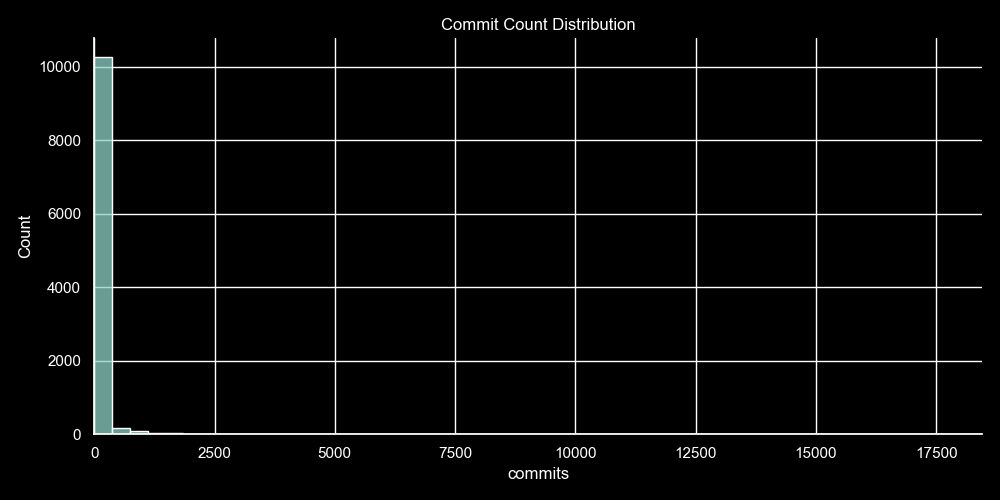

In [6]:
displot(df['commits'], 'figure1.png', 50, 'Commit Count Distribution')

/Users/brenden/dev/contribution-distribution/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/cb/qnzd2kkn7wlb1d_lvxpz08040000gn/T/ipykernel_99129/2290784480.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


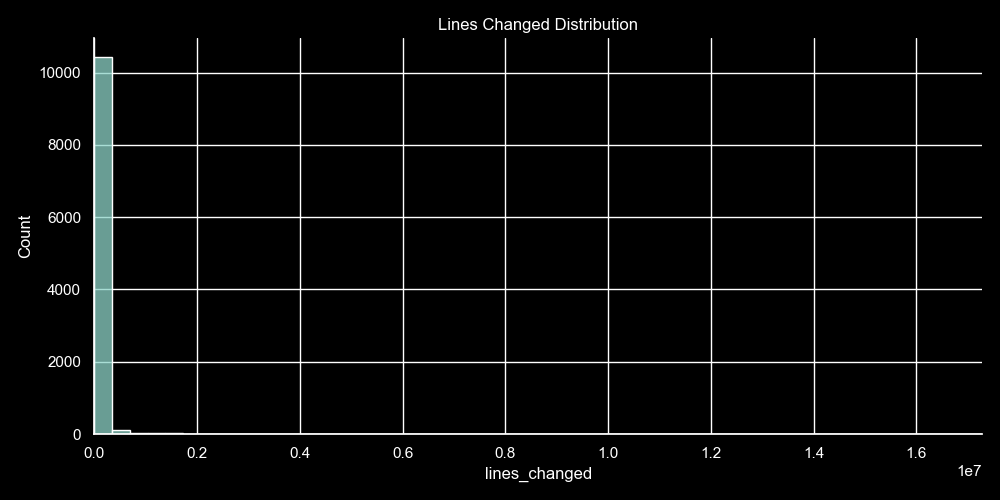

In [7]:
displot(df['lines_changed'], 'figure2.png', 50, 'Lines Changed Distribution')

In [8]:
df['commits'].describe()

count    10652.000000
mean        70.530229
std        485.271929
min          1.000000
25%          1.000000
50%          3.000000
75%         13.000000
max      18452.000000
Name: commits, dtype: float64

In [23]:
df['commits'].sum()

751288

In [37]:
p = [20, 50, 80, 99]
m = 'commits'
cdf = pd.DataFrame({'value':np.percentile(df[m], p)},index=p)
cdf.index.name = 'percentile'
cdf['count_below'] = [(df[m] <= value).sum() for _index, value in cdf['value'].items()]
cdf['count_above'] = [(df[m] > value).sum() for _index, value in cdf['value'].items()]
cdf['total'] = [df.loc[(df[m] > value), m].sum() for _index, value in cdf['value'].items()]
cdf['total_share'] = [df.loc[(df[m] > value), m].sum() / df[m].sum() for _index, value in cdf['value'].items()]
cdf

,value,count_below,count_above,total,total_share
percentile,,,,,
20,1.00,3332,7320,747956,0.995565
50,3.00,5707,4945,742368,0.988127
80,22.00,8550,2102,717413,0.954911
99,1267.39,10545,107,362867,0.482993


In [38]:
df['lines_changed'].describe()

count    1.065200e+04
mean     4.462516e+04
std      4.481878e+05
min      0.000000e+00
25%      1.000000e+01
50%      8.500000e+01
75%      1.031000e+03
max      1.727534e+07
Name: lines_changed, dtype: float64

In [39]:
df['lines_changed'].sum()

475347169

In [40]:
p = [20, 50, 80, 99]
m = 'lines_changed'
cdf = pd.DataFrame({'value':np.percentile(df[m], p)},index=p)
cdf.index.name = 'percentile'
cdf['count_below'] = [(df[m] <= value).sum() for _index, value in cdf['value'].items()]
cdf['count_above'] = [(df[m] > value).sum() for _index, value in cdf['value'].items()]
cdf['total'] = [df.loc[(df[m] > value), m].sum() for _index, value in cdf['value'].items()]
cdf['total_share'] = [df.loc[(df[m] > value), m].sum() / df[m].sum() for _index, value in cdf['value'].items()]
cdf

,value,count_below,count_above,total,total_share
percentile,,,,,
20,6.00,2265,8387,475340231,0.999985
50,85.00,5330,5322,475243385,0.999782
80,2168.00,8522,2130,473527673,0.996172
99,854361.82,10545,107,327472221,0.688912
